In [1]:
import os,subprocess
workdir='/mnt/Data1/ribli/splicing_code/modelling/'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

#theano gpu
os.environ['THEANO_FLAGS']='device=gpu'

#import sys
#sys.path.append('../my_modules')
#from loading_utils import read_my_data

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot')
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import gc

def read_my_data(fname,**kwargs):
    """Load my data from file into np.arrays.
    
    I had to use garbage collector, because pandas read_csv leaves garbage around.
    """
    
    #load data
    print "Loading data... "
    x=pd.read_csv(fname,sep='\t',header=None)
    
    # for some reason not everything is cleaned up
    #when using the pandas read_csv
    gc.collect()
    
    #probe_id=x[0]
    #y=x.iloc[:,-1].values.astype(np.int8)
    #x=x.iloc[:,1:-1].values.astype(np.int8)
    #return probe_id,x,y
    
    return x.iloc[:,:-1].values.astype(np.int8),x.iloc[:,-1].values.astype(np.float64)

In [3]:
train_x,train_y = read_my_data(fname='../prepare_data/naive_feat_vect.csv')
print train_x.shape

Loading data... 
(10097, 800)


In [4]:
#make it image like
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train_x=lb.fit_transform(np.concatenate([train_x.flatten()])).reshape((-1,1,800,4))
print train_x.shape

(10097, 1, 800, 4)


In [5]:
train_y=(0.5*(np.sign(train_y-np.median(train_y))+1)).astype(np.int8)

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,MaxPooling2D
from keras.regularizers import l2

input_dim=train_x.shape[2]
activation='relu'
loss='binary_crossentropy'
optimizer='adam'
init='glorot_normal'
pool_size=(781,1)
window_size=20

model = Sequential()

#Convolution layer
model.add(Convolution2D(100,window_size,4, border_mode='valid',
                        input_shape=(1,input_dim,4),W_regularizer=l2(0.01)))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
#model.add(Dropout(0.2))

#final layer
model.add(Dense(1, activation='sigmoid'))

#compile model
model.compile(loss=loss,optimizer=optimizer,class_mode='binary')

In [35]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
def fit_keras_model(model,train_x,train_y,test_x,test_y,validation_split=0.05):
    start=time.time()
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
    early_stop=EarlyStopping(patience=5,verbose=1)
    
    #train it
    callb_hist=model.fit(train_x,train_y,nb_epoch = 100,
                         show_accuracy=True,verbose=1,
                        validation_split=validation_split,
                        callbacks=[best_model,early_stop])
    #predict
    model.load_weights('best_model')
    train_pred=model.predict_classes(train_x).ravel()
    test_pred=model.predict_classes(test_x).ravel()
    
    train_pred_pr=model.predict(train_x).ravel()
    test_pred_pr=model.predict(test_x).ravel()

    #check errors
    print 'train accuracy:',list((train_pred==train_y)).count(True)/float(len(train_y))
    print 'test accuracy:',list((test_pred==test_y)).count(True)/float(len(test_y))

    print 'It took:',time.time()-start    
    return train_pred,test_pred,train_pred_pr,test_pred_pr

In [36]:
N_train=8000
N_test=2000

train_pred,test_pred,train_pred_pr,test_pred_pr=fit_keras_model(
    model,train_x[:N_train],train_y[:N_train],
    train_x[N_train:N_train+N_test],train_y[N_train:N_train+N_test],
    validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 7s - loss: 1.3896 - acc: 0.5109 - val_loss: 0.6931 - val_acc: 0.5125
Epoch 00000: val_loss improved from inf to 0.69315, saving model to best_model
Epoch 2/100
6400/6400 [==============================] - 6s - loss: 1.0864 - acc: 0.5606 - val_loss: 0.6903 - val_acc: 0.5387
Epoch 00001: val_loss improved from 0.69315 to 0.69034, saving model to best_model
Epoch 3/100
6400/6400 [==============================] - 6s - loss: 0.9199 - acc: 0.5794 - val_loss: 0.6809 - val_acc: 0.5631
Epoch 00002: val_loss improved from 0.69034 to 0.68089, saving model to best_model
Epoch 4/100
6400/6400 [==============================] - 6s - loss: 0.8307 - acc: 0.5886 - val_loss: 0.6770 - val_acc: 0.5719
Epoch 00003: val_loss improved from 0.68089 to 0.67697, saving model to best_model
Epoch 5/100
6400/6400 [==============================] - 6s - loss: 0.7779 - acc: 0.6144 - val_loss: 0.6746 - val_acc: 0

### roc auc

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

from sklearn import metrics
def plot_roc(y,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y,probs)
    auc=metrics.roc_auc_score(y,probs)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,lw=2)
    plt.plot([0,1],[0,1],lw=2)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    print 'auc:',auc

auc: 0.650658642153


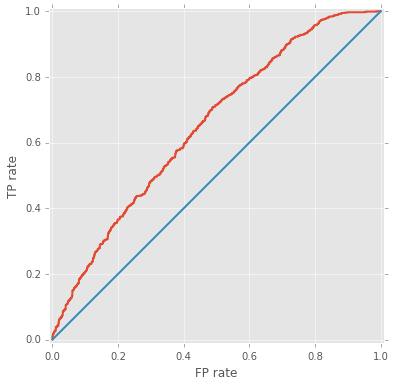

In [38]:
plot_roc(train_y[N_train:N_train+N_test],test_pred_pr)

### Kernels

In [40]:
conv1=model.layers[0]
weigths,bias=conv1.get_weights()

dense1=model.layers[4]
weigths2,bias2=dense1.get_weights()

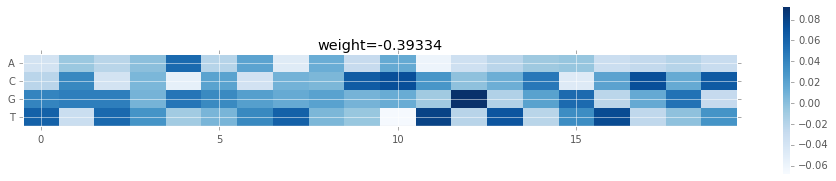

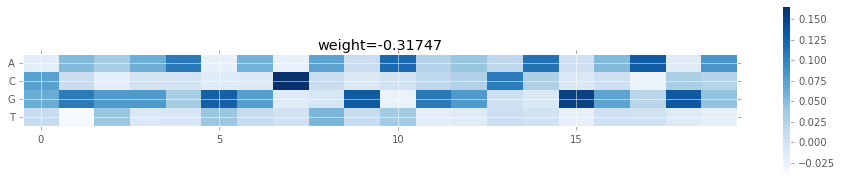

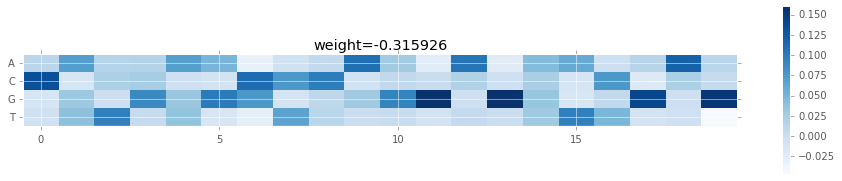

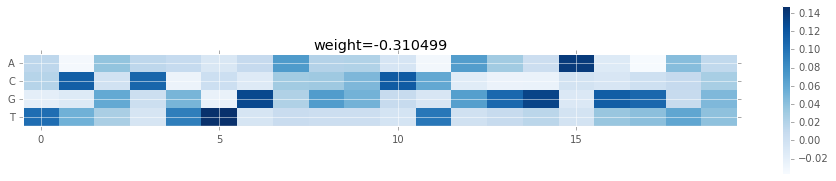

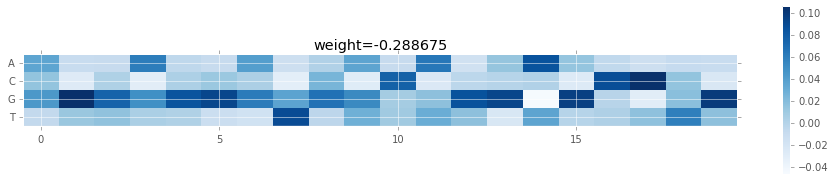

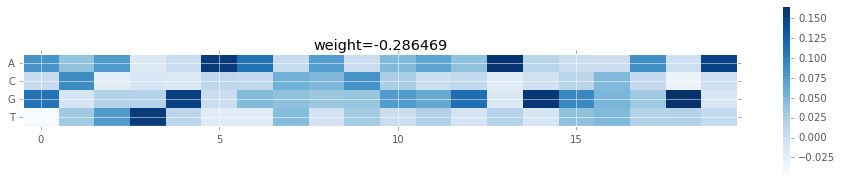

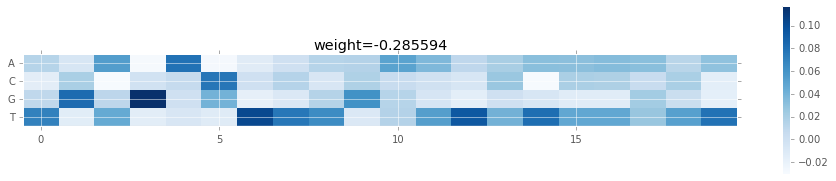

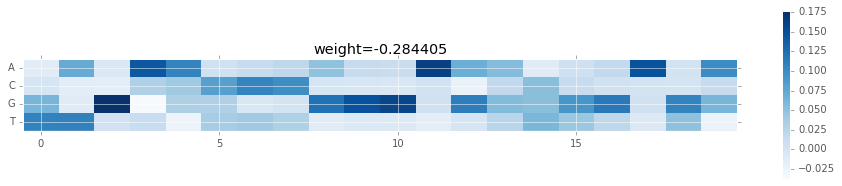

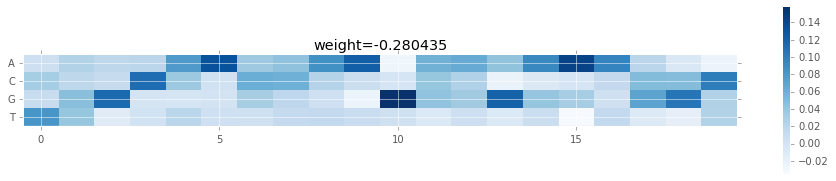

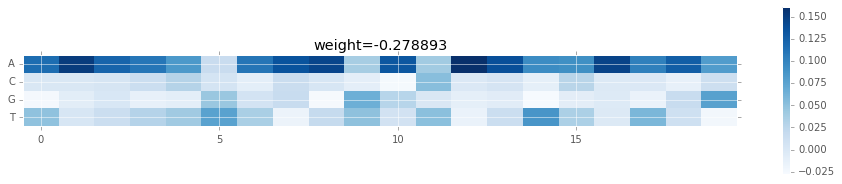

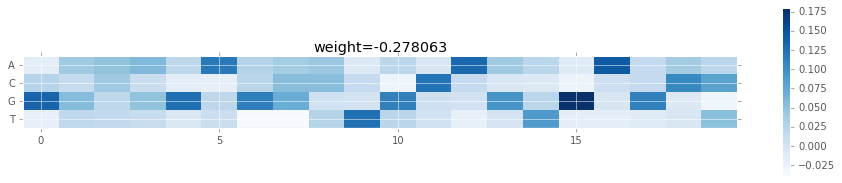

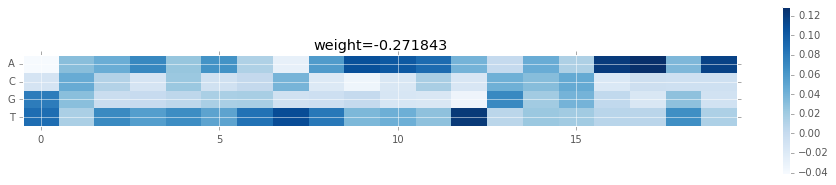

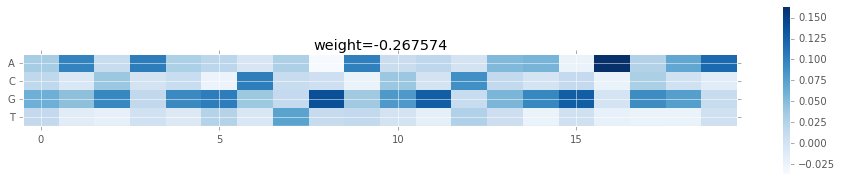

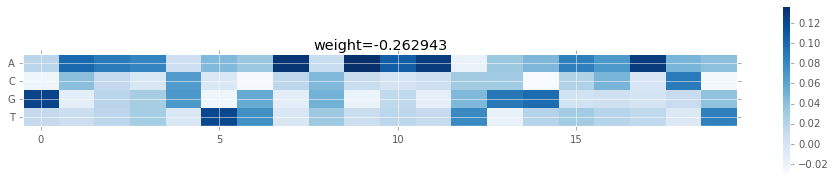

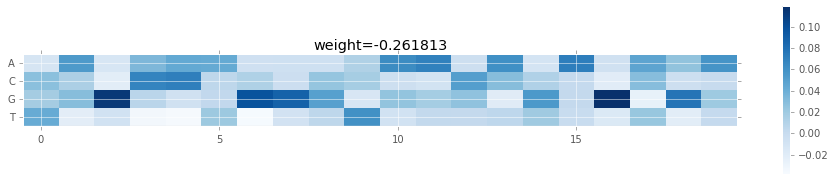

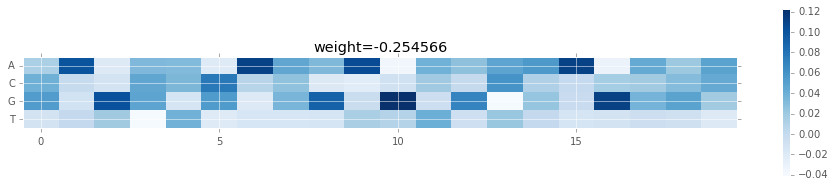

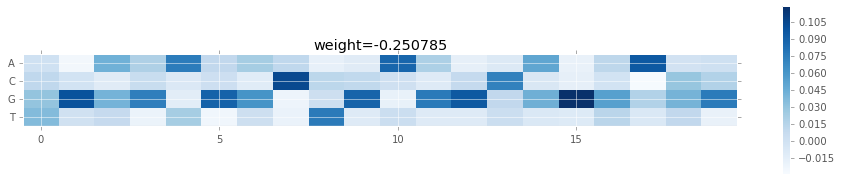

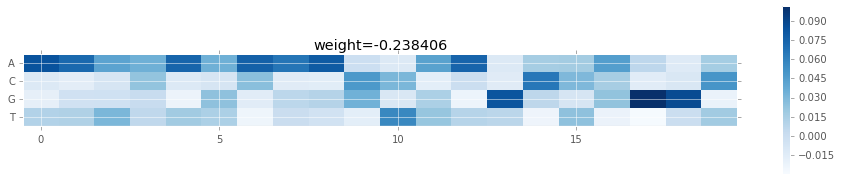

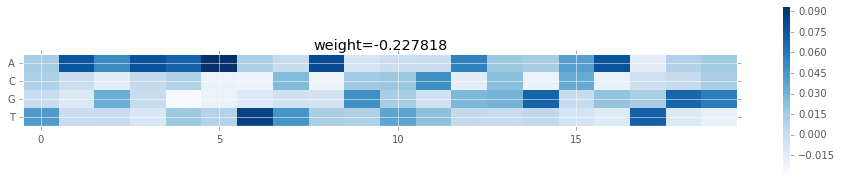

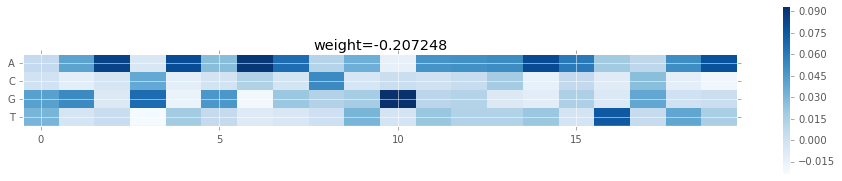

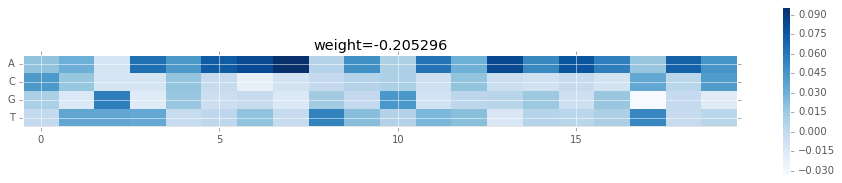

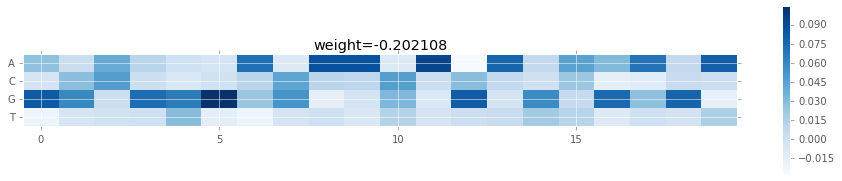

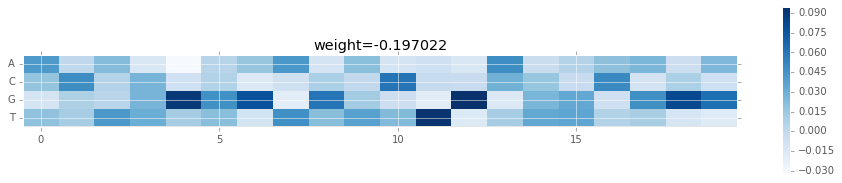

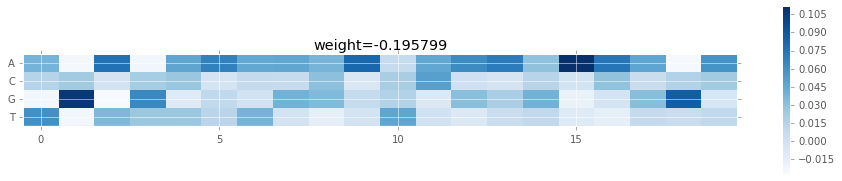

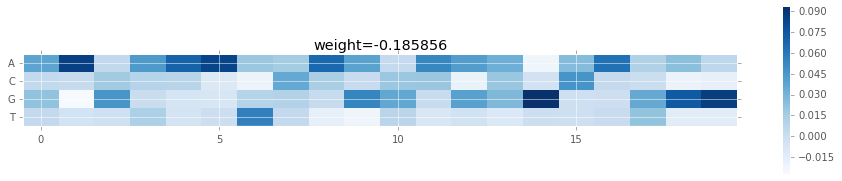

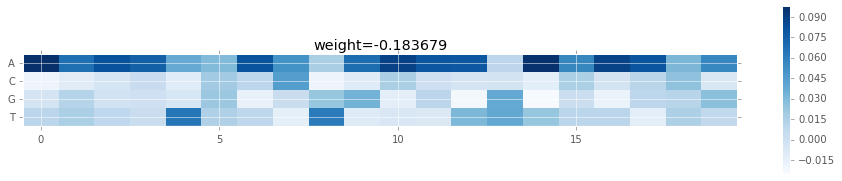

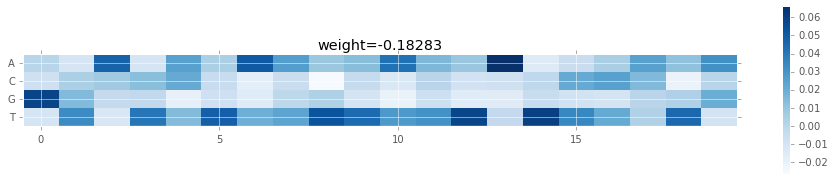

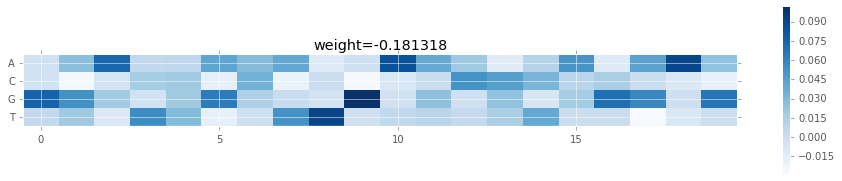

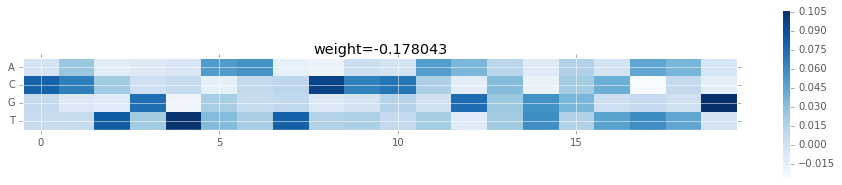

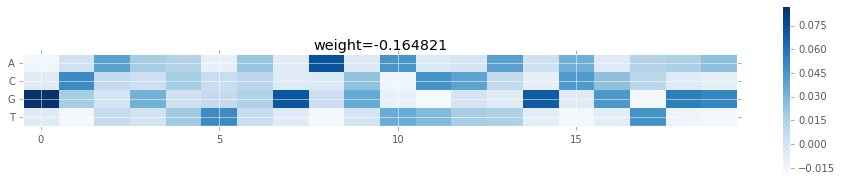

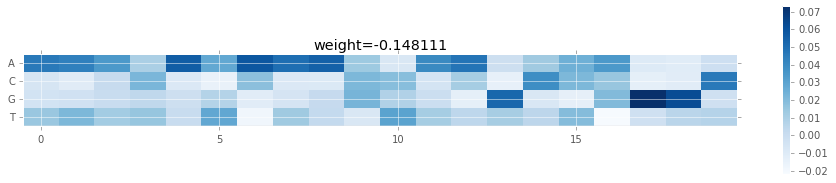

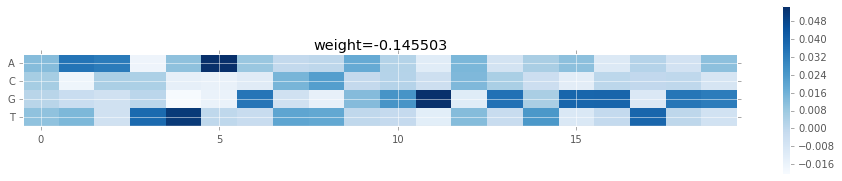

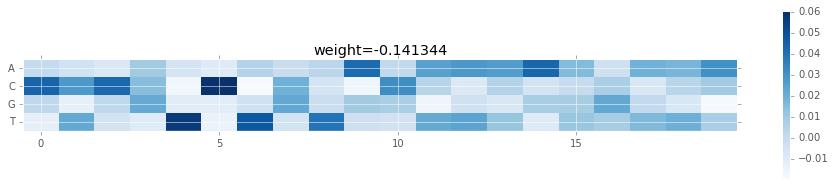

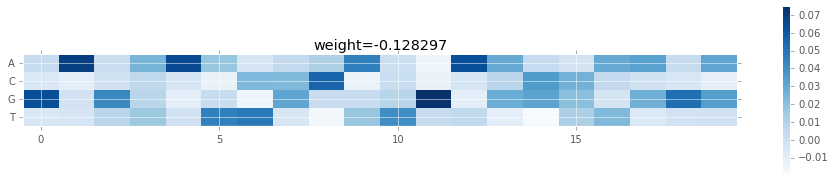

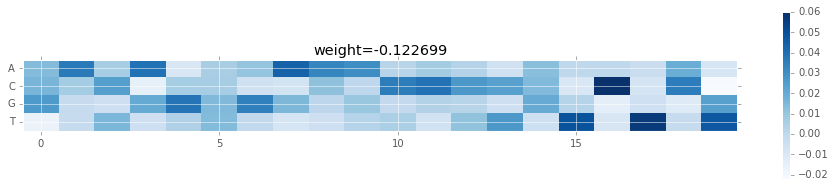

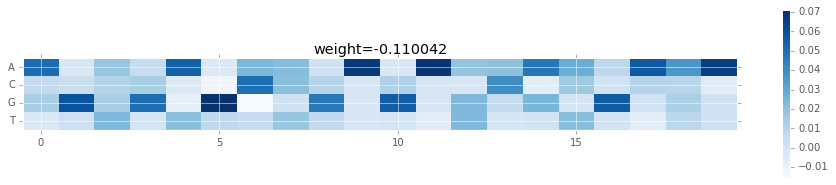

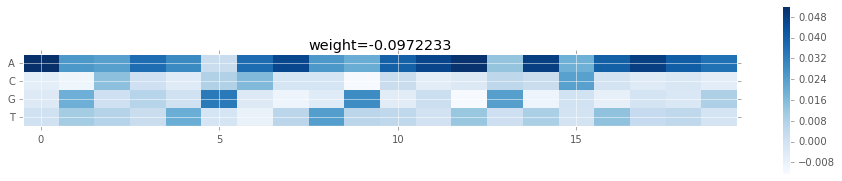

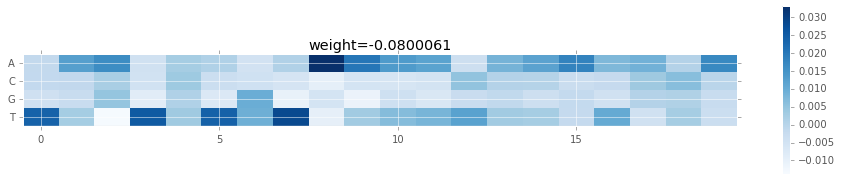

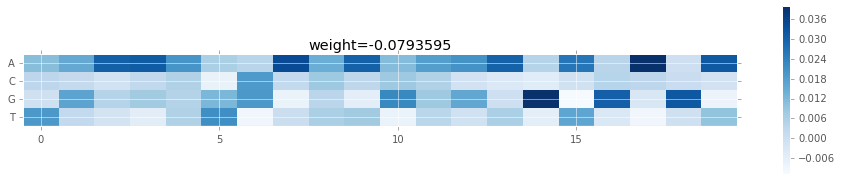

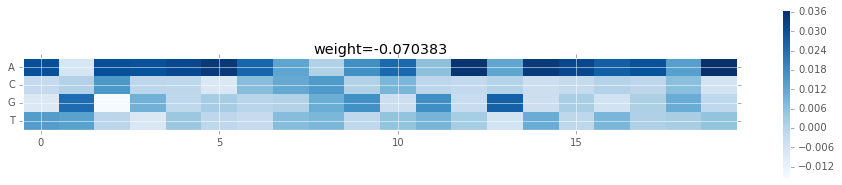

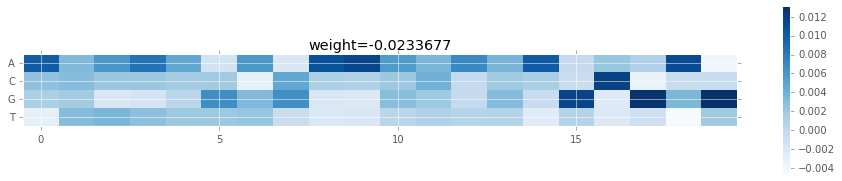

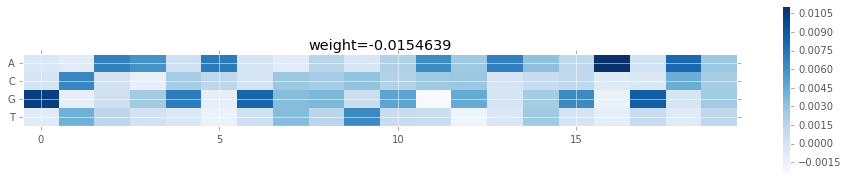

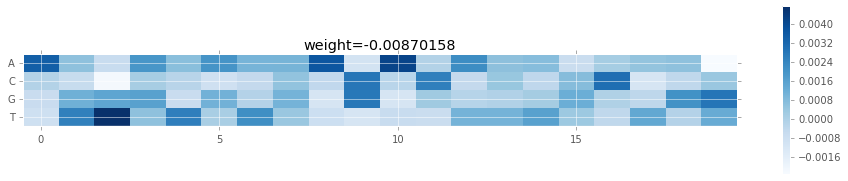

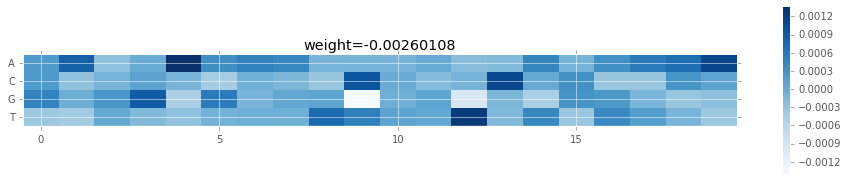

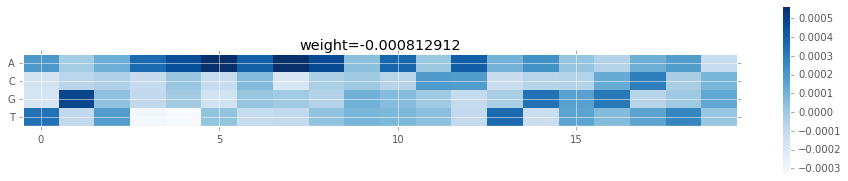

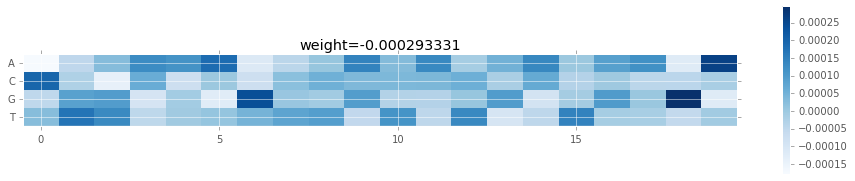

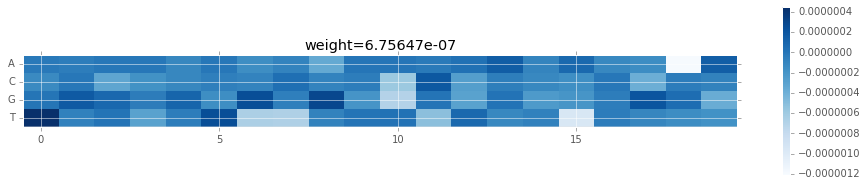

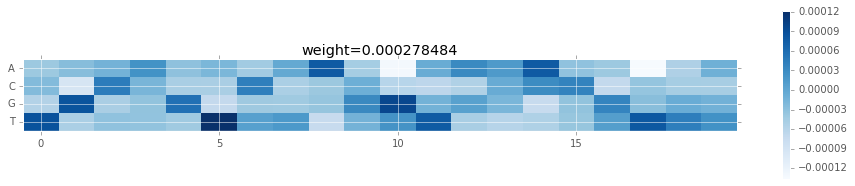

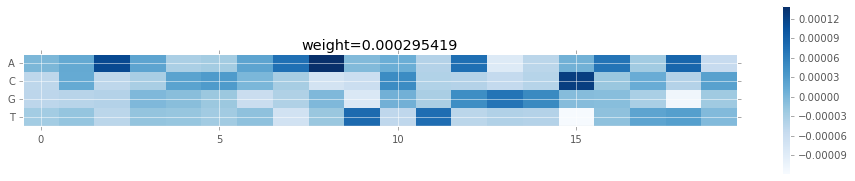

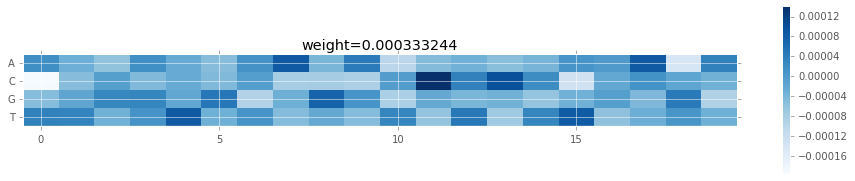

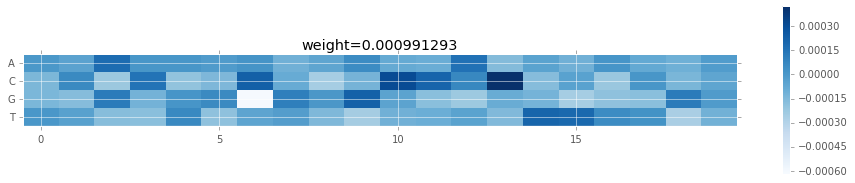

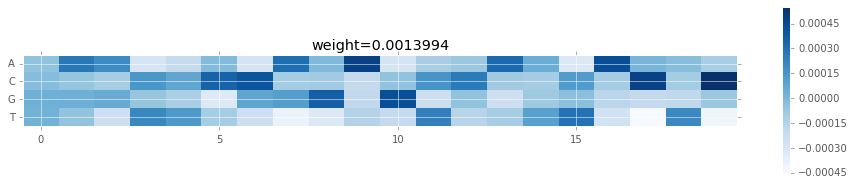

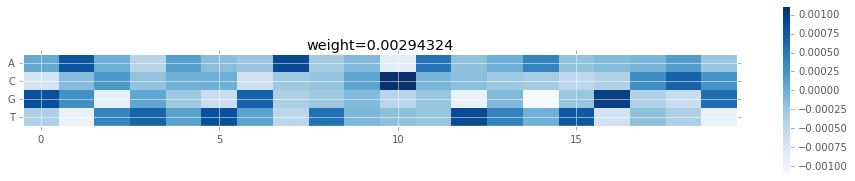

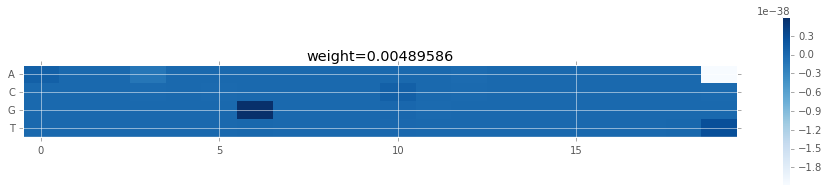

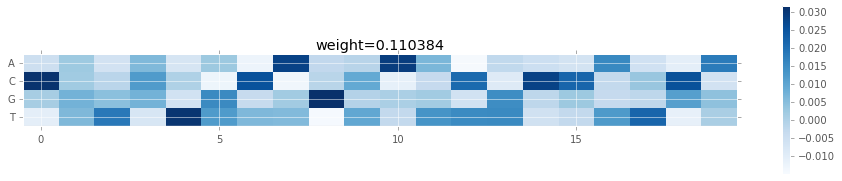

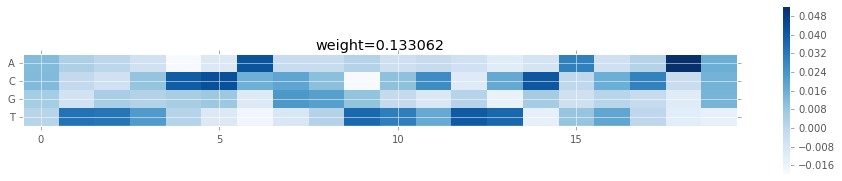

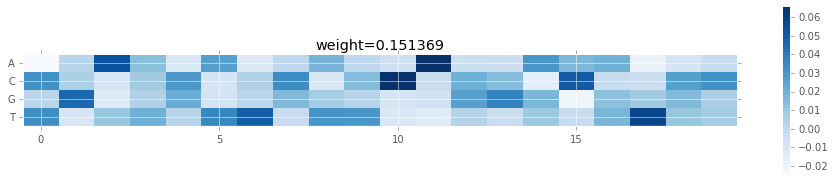

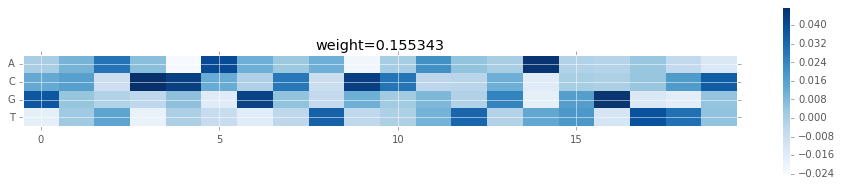

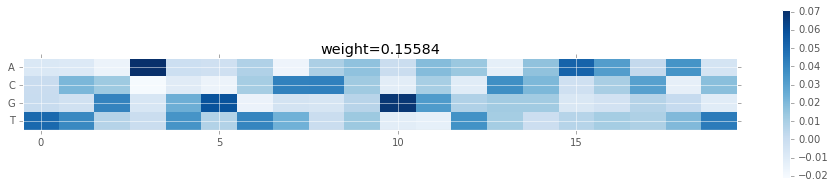

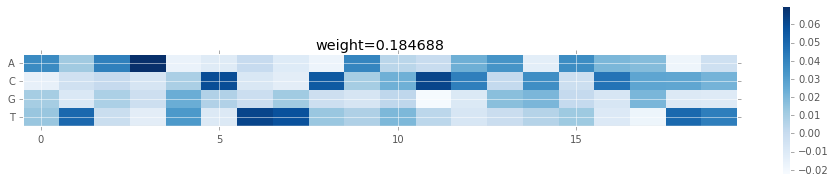

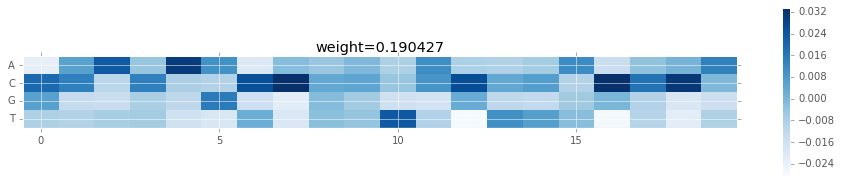

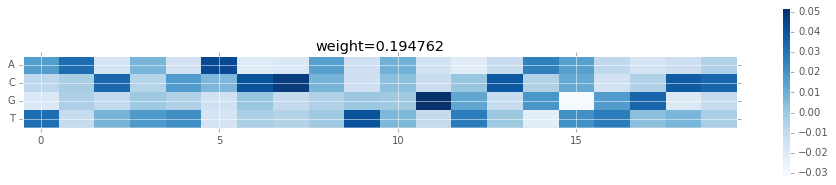

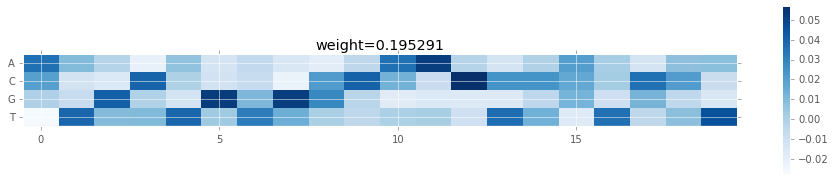

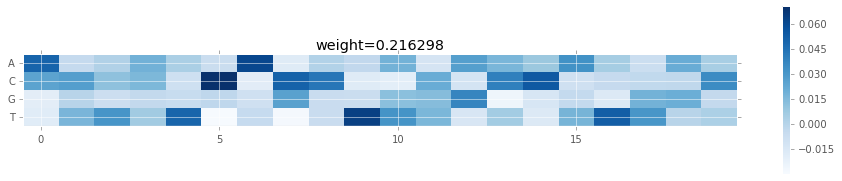

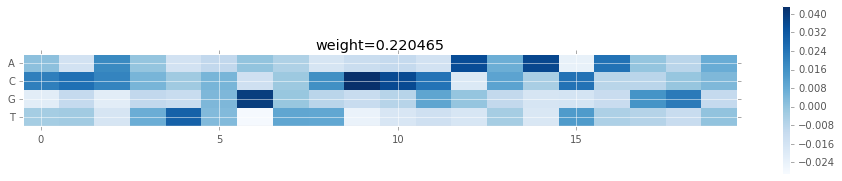

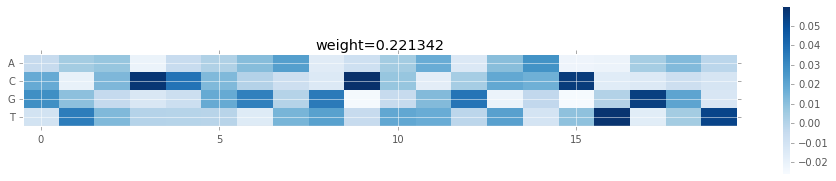

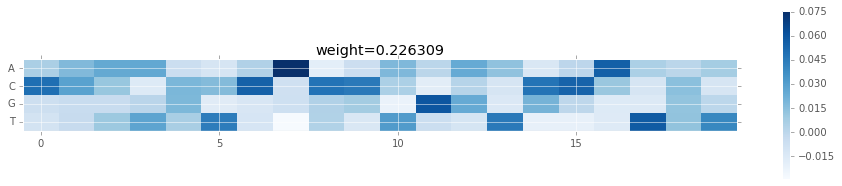

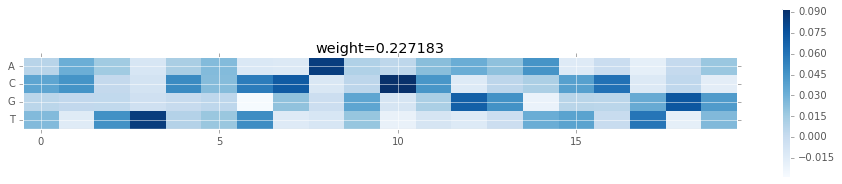

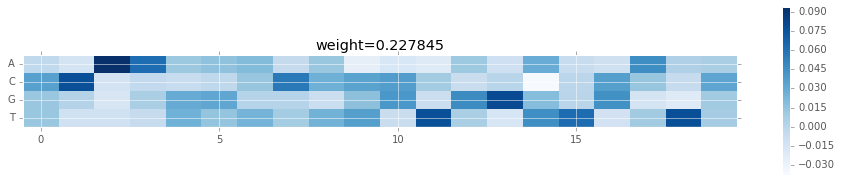

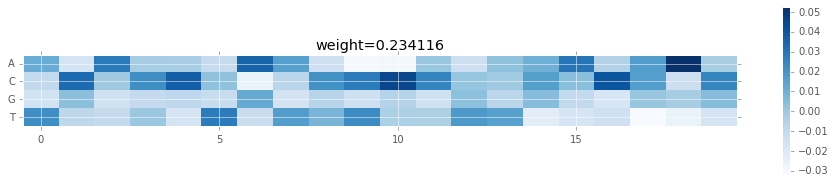

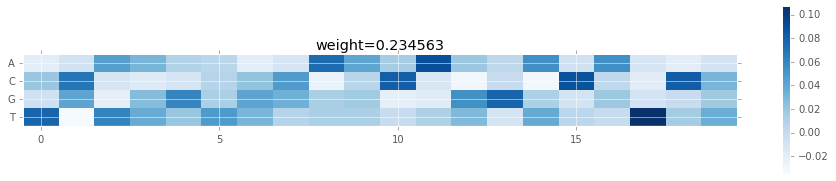

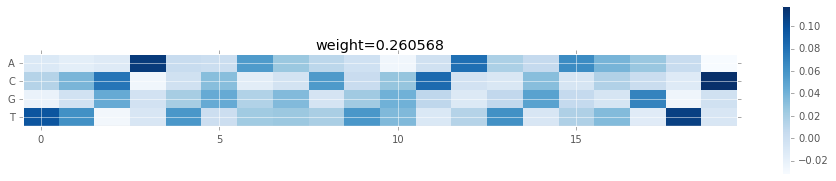

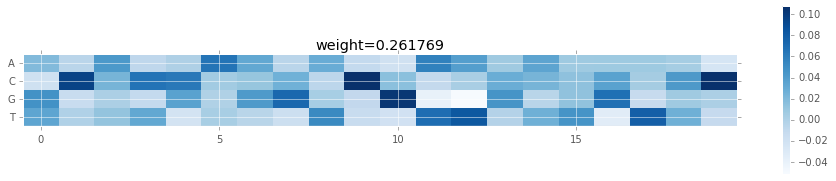

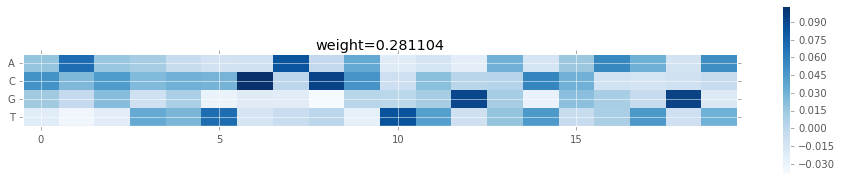

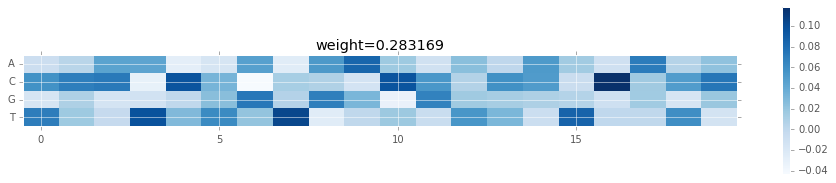

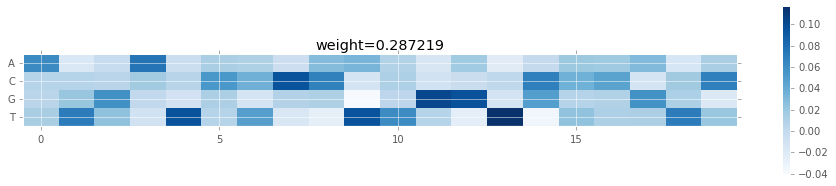

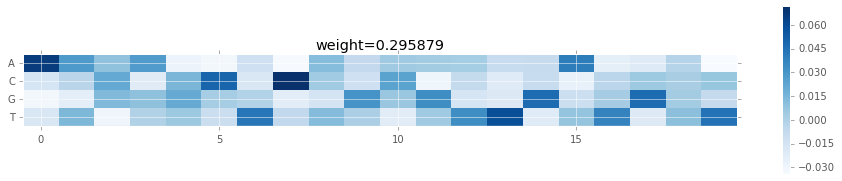

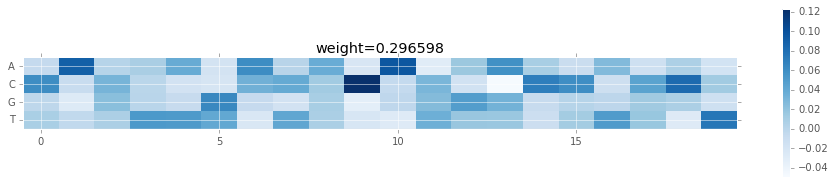

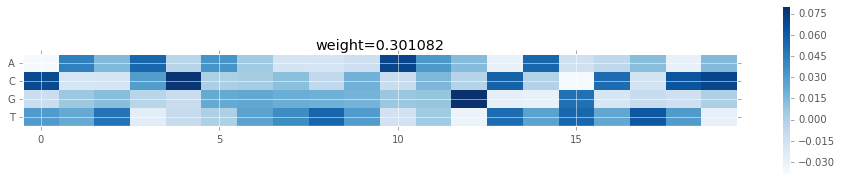

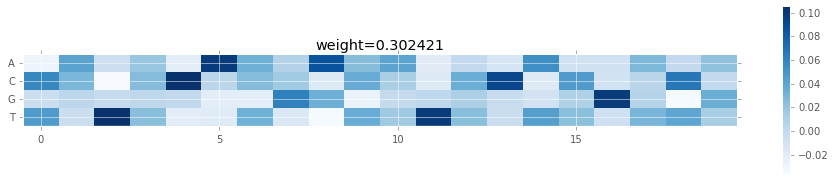

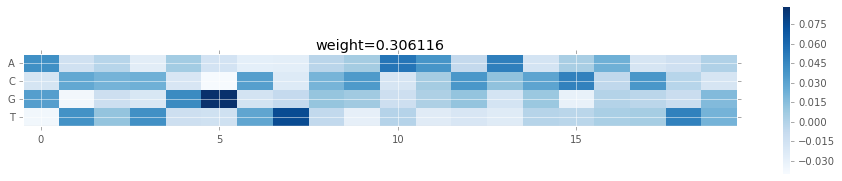

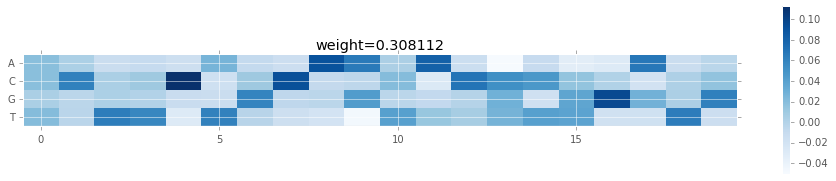

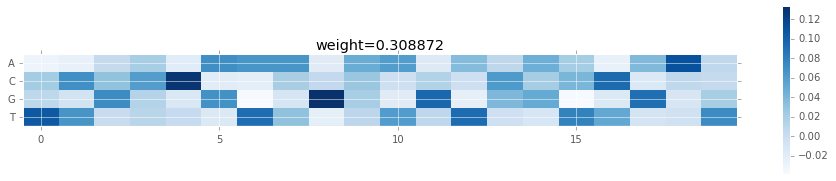

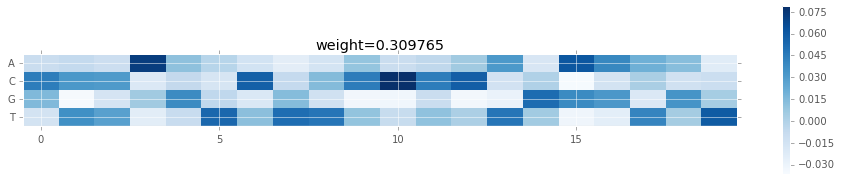

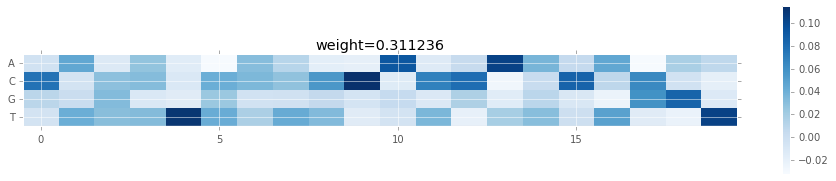

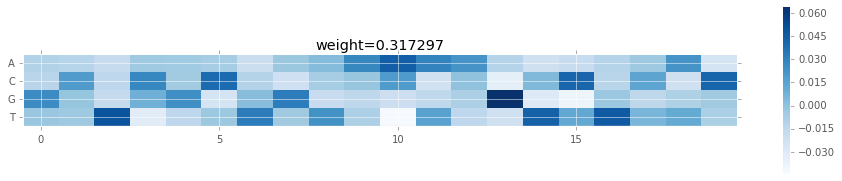

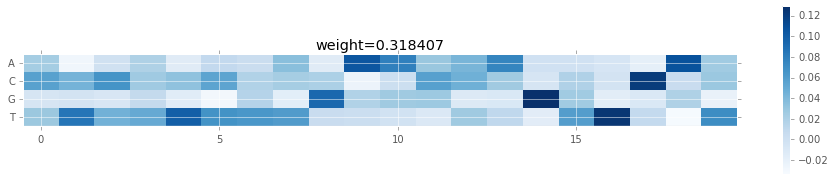

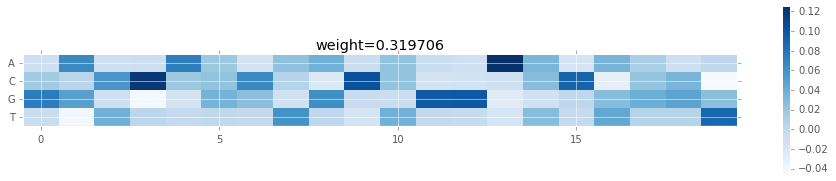

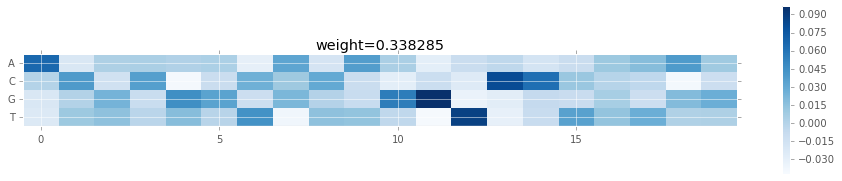

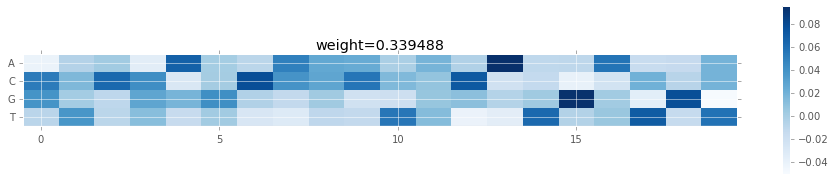

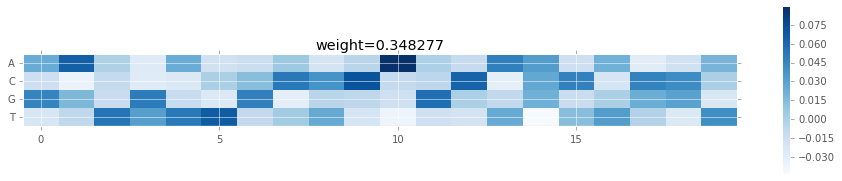

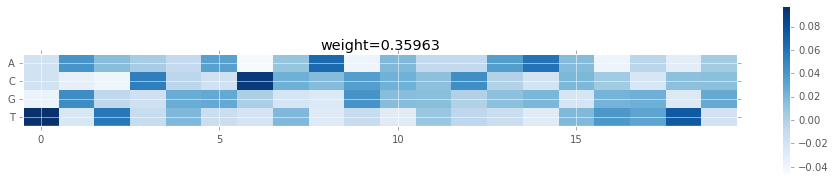

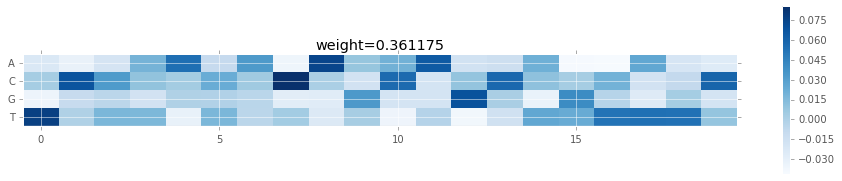

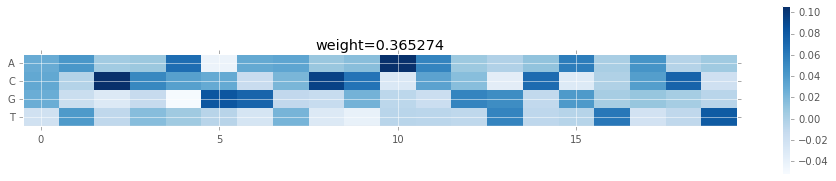

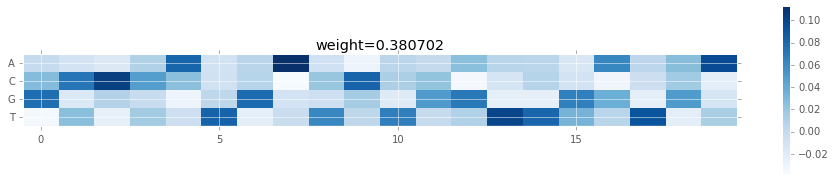

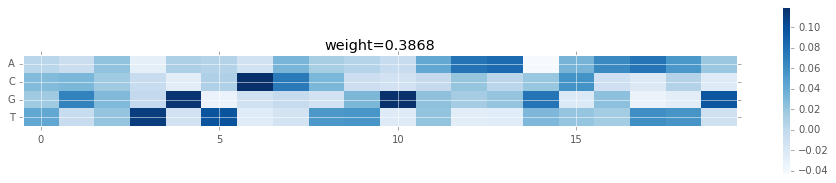

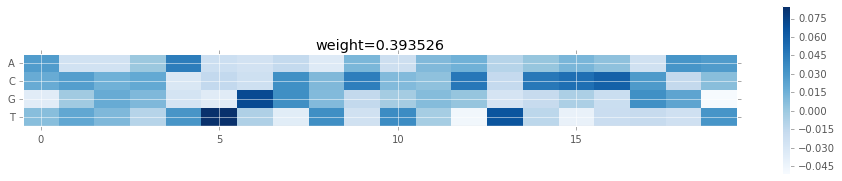

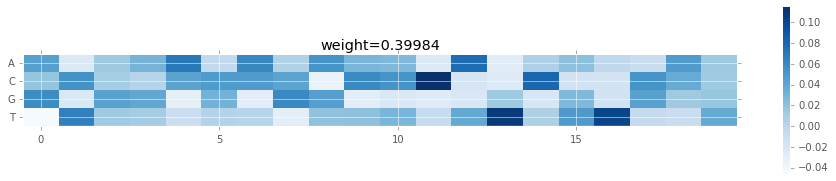

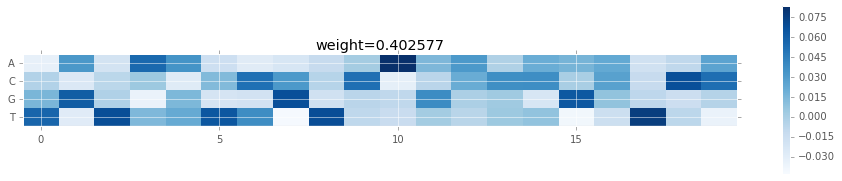

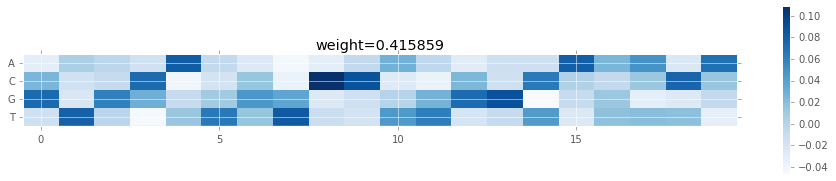

In [42]:
idx=np.argsort(weigths2.flatten())
for w,w2 in zip(weigths[idx],weigths2[idx]):
    plt.figure(figsize=(16,3))
    plt.imshow(w[0].T,interpolation='none',aspect=0.5,cmap='Blues')
    plt.colorbar()
    plt.title('weight='+str(w2[0]))
    dump=plt.yticks([0,1,2,3],['A','C','G','T'])